# TASK 3
Detection of "fake news" - classification of articles with titles. The goal of the task is to develop a classifier that will assign one of four classes based on the content and title of the article (see source for details).

Sources and explanations of the data:
http://www.fakenewschallenge.org/


**Input** : A headline and a body text - either from the same news article or from two different articles.

**Output**: Classify the stance of the body text relative to the claim made in the headline into one of four categories:
* Agrees: The body text agrees with the headline.
* Disagrees: The body text disagrees with the headline.
* Discusses: The body text discuss the same topic as the headline, but does not take a position
* Unrelated: The body text discusses a different topic than the headline

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from nltk.util import ngrams

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

Read train data

In [2]:
train_bodies = pd.read_csv('fnc-1-master/train_bodies.csv')
train_stances = pd.read_csv('fnc-1-master/train_stances.csv')

In [3]:
train_bodies.head()

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [4]:
train_stances.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [5]:
train_bodies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Body ID      1683 non-null   int64 
 1   articleBody  1683 non-null   object
dtypes: int64(1), object(1)
memory usage: 19.8+ KB


In [6]:
train_stances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  49972 non-null  object
 1   Body ID   49972 non-null  int64 
 2   Stance    49972 non-null  object
dtypes: int64(1), object(2)
memory usage: 780.9+ KB


Drop duplicates

In [10]:
train_bodies.duplicated().sum(), train_stances.duplicated().sum()

(0, 402)

In [12]:
train_stances.drop_duplicates(inplace=True)

In [13]:
train_bodies.duplicated().sum(), train_stances.duplicated().sum()

(0, 0)

Stance values distribution

<AxesSubplot:>

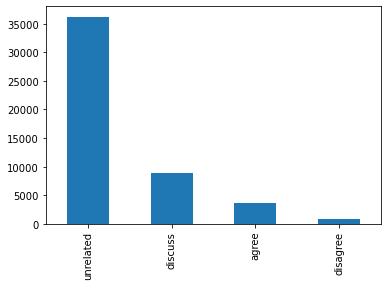

In [19]:
train_stances['Stance'].value_counts().plot.bar()

Distribution of classes is imbalanced, unrelated class significantly dominates over the other classes

To deal with this disorder, one can use methods such as:
* undersampling - random elimination of minority class samples until class balance is achieved
* oversampling - random duplication of minority class instances

Body ID distribution

<AxesSubplot:>

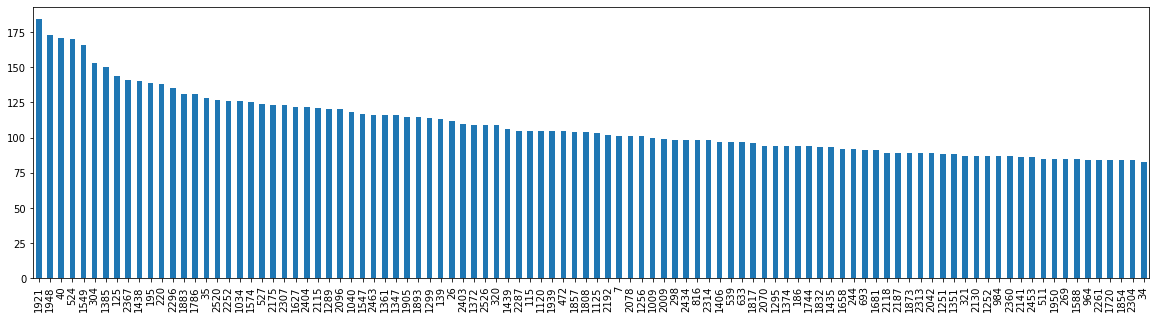

In [27]:
train_stances['Body ID'].value_counts()[:100].plot.bar(figsize=(20,5))

In [58]:
train_stances.groupby(["Body ID", "Stance"]).count()[:10]

Headline
Body ID Stance             
0       agree             1
        unrelated        35
4       discuss           1
5       discuss           2
        unrelated        53
6       discuss           1
7       discuss           2
        unrelated        99
8       agree             1
        unrelated        42

One may notice that major part of instances with unrelated stance can be deleted in order to undersample data

### The modelling will be divided into to parts:
* PART 1 - cleaning texts and classification of headlines without undersampling
* PART 2 - classification with undersampling of data

#### PART 1

Functions for text preprocessing

In [60]:
def convert_to_sentences(article):
    return article.split(".")

def remove_whitespaces(article):
    article = [line.strip() for line in article]
    article = [line for line in article if line]
    return article 

def convert_to_lowercase(article):
    return [line.lower() for line in article]

def remove_punctuation(article):
    return [line.translate(str.maketrans('', '', string.punctuation)) for line in article]

def remove_stopwords(article):
    stopwords = set(nltk_stopwords.words('english'))
    return [word for word in article if word not in stopwords]

def tokenize(article):
    return word_tokenize(article)

def remove_non_alnum(article):
    return [word for word in article if word.isalnum()]

def preprocess_text(article):
    article = convert_to_sentences(article)
    article = remove_whitespaces(article)
    article = remove_punctuation(article)
    article = convert_to_lowercase(article)
    article = ''.join(article)
    article = tokenize(article)
    article = remove_stopwords(article)
    article = remove_non_alnum(article)
    return article

Cleaning bodies and headlines and merging dataframes into one

In [61]:
train_bodies['bodyWords'] = train_bodies['articleBody'].apply(preprocess_text)
train_stances['headlineWords'] = train_stances['Headline'].apply(preprocess_text)
train = pd.merge(train_bodies, train_stances, on='Body ID')
train = train[['Body ID', 'bodyWords', 'headlineWords', 'Stance']]
train.head()

,Body ID,bodyWords,headlineWords,Stance
0,0,"[small, meteorite, crashed, wooded, area, nica...","[soldier, shot, parliament, locked, gunfire, e...",unrelated
1,0,"[small, meteorite, crashed, wooded, area, nica...","[tourist, dubbed, spider, man, spider, burrows...",unrelated
2,0,"[small, meteorite, crashed, wooded, area, nica...","[luke, somers, killed, failed, rescue, attempt...",unrelated
3,0,"[small, meteorite, crashed, wooded, area, nica...","[breaking, soldier, shot, war, memorial, ottawa]",unrelated
4,0,"[small, meteorite, crashed, wooded, area, nica...","[giant, 8ft, 9in, catfish, weighing, 19, stone...",unrelated


Feature extraction by counting ngrams of headlines which appear in body text of articles

In [63]:
def n_grams_count(clean_body, clean_headline, n):
    n_grams_count = []
    for body, headline in zip(clean_body, clean_headline):
        counter = 0
        for headline_ngram in ngrams(headline, n=n):
            if headline_ngram in set(ngrams(body, n=n)):
                counter += 1
        n_grams_count.append(counter)
    return n_grams_count

In [64]:
for i in range(2,6):
    train[f'ngrams_{i}'] = n_grams_count(train['bodyWords'], train['headlineWords'], i)
train

,Body ID,bodyWords,headlineWords,Stance,ngrams_2,ngrams_3,ngrams_4,ngrams_5
0,0,"[small, meteorite, crashed, wooded, area, nica...","[soldier, shot, parliament, locked, gunfire, e...",unrelated,0,0,0,0
1,0,"[small, meteorite, crashed, wooded, area, nica...","[tourist, dubbed, spider, man, spider, burrows...",unrelated,0,0,0,0
2,0,"[small, meteorite, crashed, wooded, area, nica...","[luke, somers, killed, failed, rescue, attempt...",unrelated,0,0,0,0
3,0,"[small, meteorite, crashed, wooded, area, nica...","[breaking, soldier, shot, war, memorial, ottawa]",unrelated,0,0,0,0
4,0,"[small, meteorite, crashed, wooded, area, nica...","[giant, 8ft, 9in, catfish, weighing, 19, stone...",unrelated,0,0,0,0
...,...,...,...,...,...,...,...,...
49565,2532,"[ann, arbor, pizza, delivery, man, michigan, g...","[pizza, delivery, driver, surprised, 2000, tip]",agree,2,0,0,0
49566,2532,"[ann, arbor, pizza, delivery, man, michigan, g...","[pizza, delivery, man, gets, tipped, 2000, sin...",agree,2,1,0,0
49567,2532,"[ann, arbor, pizza, delivery, man, michigan, g...","[pizza, delivery, man, gets, 2000, tip]",agree,2,1,0,0
49568,2532,"[ann, arbor, pizza, delivery, man, michigan, g...","[luckiest, pizza, delivery, guy, ever, gets, 2...",agree,1,0,0,0


Mapping classes to discrete values:
0 - UNRELATED, 1 - AGREE, 2 - DISCUSS, 3 - DISAGREE

In [191]:
mapping = {'unrelated': 0, 'agree': 1, 'discuss': 2, 'disagree': 3}

X = train.iloc[:,-4:].values
y = train['Stance'].map(mapping).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [68]:
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, criterion='entropy'),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100),
    'KNearestNeighbor': KNeighborsClassifier(n_neighbors=5),
    'SVC': SVC(),
    'DecisionTree': DecisionTreeClassifier(),
    'GaussianNB': GaussianNB(),
}

In [69]:
results = pd.DataFrame(np.zeros((3, len(models))), columns=models.keys(), index=['accuracy', 'precision', 'recall'])
for model in models.keys():
    print(model)
    models[model].fit(X_train, y_train)
    y_pred = models[model].predict(X_test)
    results[model] = [accuracy_score(y_test, y_pred)] + list(precision_recall_fscore_support(y_test, y_pred, average='micro')[:2])

RandomForest
GradientBoosting
KNearestNeighbor
SVC
DecisionTree
GaussianNB


In [70]:
results = results.T.round(4) * 100
results

,accuracy,precision,recall
RandomForest,84.41,84.41,84.41
GradientBoosting,84.40,84.40,84.40
KNearestNeighbor,83.97,83.97,83.97
SVC,84.38,84.38,84.38
DecisionTree,84.38,84.38,84.38
GaussianNB,84.01,84.01,84.01


In [71]:
results.index[results['accuracy'].argmax()], results['accuracy'].max()

('RandomForest', 84.41)

#### Best model - Random Forest

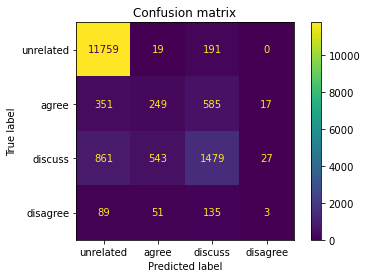

In [192]:
model = RandomForestClassifier(class_weight='balanced').fit(X_train, y_train)
ax = plt.subplot()
y_pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test, ax=ax)
ax.set_title("Confusion matrix")
ax.set(xticklabels=mapping.keys(), yticklabels=mapping.keys())
plt.show()

In [193]:
report1 = classification_report(y_test, y_pred, target_names=mapping.keys())
print(report1)

              precision    recall  f1-score   support

   unrelated       0.90      0.98      0.94     11969
       agree       0.29      0.21      0.24      1202
     discuss       0.62      0.51      0.56      2910
    disagree       0.06      0.01      0.02       278

    accuracy                           0.82     16359
   macro avg       0.47      0.43      0.44     16359
weighted avg       0.79      0.82      0.80     16359



As we may notice metrics for less numerous classes are much lower

#### PART 2

In [182]:
train['Body ID'].value_counts()[:600]

1921    184
1948    173
40      171
524     170
1549    166
       ... 
608      32
714      32
2508     32
2336     32
311      32
Name: Body ID, Length: 600, dtype: int64

Delete rows which have more than 32 instances of one Body ID and Stance is 'unrelated'

In [183]:
id_to_remove = train['Body ID'].value_counts().reset_index()[:600]['index'].values

In [184]:
new_train = train.drop(train[(train['Stance'] == 'unrelated') & (train['Body ID'].isin(id_to_remove))].sample(frac=.7).index)

<AxesSubplot:>

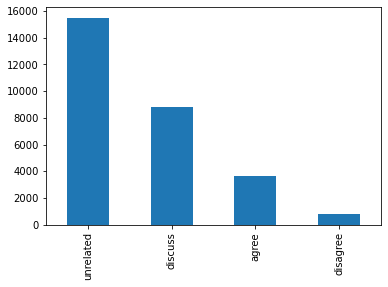

In [185]:
new_train['Stance'].value_counts().plot.bar() # NEW DISTRIBUTION

<AxesSubplot:>

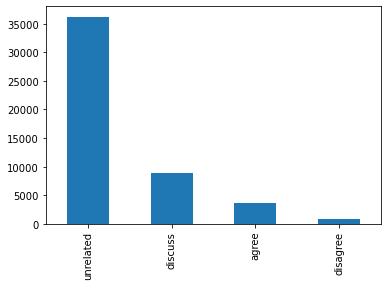

In [186]:
train['Stance'].value_counts().plot.bar() # OLD DISTRIBUTION

In [197]:
mapping = {'unrelated': 0, 'agree': 1, 'discuss': 2, 'disagree': 3}

X = new_train.iloc[:,-4:].values
y = new_train['Stance'].map(mapping).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

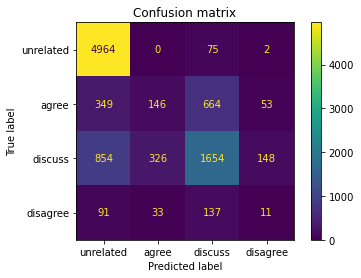

In [198]:
model = RandomForestClassifier(class_weight='balanced').fit(X_train, y_train)
y_pred = model.predict(X_test)
ax = plt.subplot()
plot_confusion_matrix(model, X_test, y_test, ax=ax)
ax.set_title("Confusion matrix")
ax.set(xticklabels=mapping.keys(), yticklabels=mapping.keys())
plt.show()

In [199]:
print(classification_report(y_test, y_pred, target_names=mapping.keys()))

              precision    recall  f1-score   support

   unrelated       0.79      0.98      0.88      5041
       agree       0.29      0.12      0.17      1212
     discuss       0.65      0.55      0.60      2982
    disagree       0.05      0.04      0.05       272

    accuracy                           0.71      9507
   macro avg       0.45      0.43      0.42      9507
weighted avg       0.66      0.71      0.68      9507



In [200]:
print("Report from PART 1")
print(report1)

Report from PART 1
              precision    recall  f1-score   support

   unrelated       0.90      0.98      0.94     11969
       agree       0.29      0.21      0.24      1202
     discuss       0.62      0.51      0.56      2910
    disagree       0.06      0.01      0.02       278

    accuracy                           0.82     16359
   macro avg       0.47      0.43      0.44     16359
weighted avg       0.79      0.82      0.80     16359



Introduced modifications didn't bring spectacular changes in metrics results, however different methods of dealing with imbalanced classes and extraction of additional text features for modeling might be crucial 